# EDA: FLUSHOTS to ADENERGY

## Load in dataset

In [128]:
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
import os

print(os.getcwd())

/home/cs_433_mlprojects/EPFL-Machine-Learning-JEC/eda


In [129]:
X_train = pd.read_csv('../datasets/x_train.csv')
y_train = pd.read_csv('../datasets/y_train.csv')
X_test = pd.read_csv('../datasets/x_test.csv')

In [130]:
X_train.head()

,_STATE,FMONTH,IDATE,IMONTH,IDAY,IYEAR,DISPCODE,SEQNO,_PSU,CTELENUM,...,_PAREC1,_PASTAE1,_LMTACT1,_LMTWRK1,_LMTSCL1,_RFSEAT2,_RFSEAT3,_FLSHOT6,_PNEUMO2,_AIDTST3
0,53,11,11162015,11,16,2015,1100,2015015629,2015015629,NaN,...,1,1,3.0,3.0,4.0,1,1,NaN,NaN,2.0
1,33,12,12152015,12,15,2015,1200,2015004387,2015004387,1.0,...,9,9,3.0,3.0,4.0,9,9,NaN,NaN,NaN
2,20,10,10202015,10,20,2015,1100,2015005638,2015005638,1.0,...,4,2,2.0,2.0,3.0,1,1,1.0,2.0,2.0
3,42,6,6182015,6,18,2015,1100,2015004694,2015004694,NaN,...,2,2,2.0,2.0,3.0,1,1,2.0,2.0,2.0
4,24,11,11062015,11,6,2015,1100,2015004673,2015004673,1.0,...,9,9,3.0,3.0,4.0,1,1,9.0,9.0,2.0


In [131]:
y_train.head()

,_MICHD
0,0
1,0
2,0
3,0
4,0


In [132]:
# Get column names for X_train
X_train_colnames = [_ for _ in X_train.columns]
print(f'No. of columns: {len(X_train_colnames)}')
print(f'FLUSHOTS col idx: {X_train_colnames.index("FLUSHOT6")}')
print(f'ADENERGY col idx: {X_train_colnames.index("ADENERGY")}')

start_idx = X_train_colnames.index("FLUSHOT6")
end_idx = X_train_colnames.index("ADENERGY")

No. of columns: 321
FLUSHOTS col idx: 100
ADENERGY col idx: 209


In [133]:
subsetted_X_train = X_train[X_train_colnames[start_idx:end_idx + 1]]
print(f'No. of columns: {len(subsetted_X_train.columns)}')

No. of columns: 110


## Evaluation of response variable, y

In [134]:
print('Summary of unique values:')
print(y_train['_MICHD'].value_counts())

print(f'No. of NA/ missing values: {y_train["_MICHD"].isna().sum()}') # There are no missing values

Summary of unique values:
_MICHD
0    299160
1     28975
Name: count, dtype: int64
No. of NA/ missing values: 0


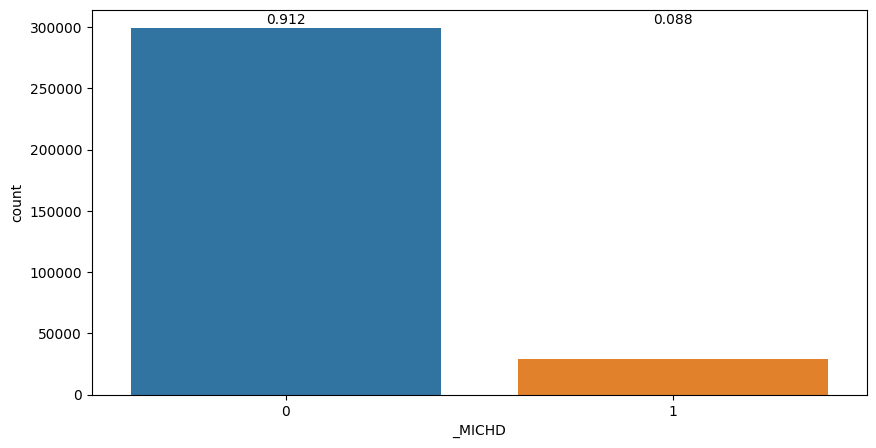

In [135]:
# Visualise proportions of response variable y
sb.countplot(y_train, x = '_MICHD')

y_train_neg = y_train[y_train['_MICHD'] == 0].index
y_train_pos = y_train[y_train['_MICHD'] == 1].index
counts = [round(len(y_train_neg)/ (len(y_train_neg)+len(y_train_pos)), 3), round(len(y_train_pos)/ (len(y_train_neg)+len(y_train_pos)), 3)]

for i, cnt in enumerate(counts):
    plt.text(i, 0.3e6 + cnt + 0.1, str(cnt), ha='center', va='bottom')

### Observation

- Data is heavily skewed towards respondents with no disease
- May have to perform upsampling later on to improve training, especially for classification tasks since skewed dataset can result in bias in predictions

## Evaluation of features, X

- Plot correlation wtih response variable, y
- Shortlisting of most correlated variables
- Correlations between features

In [136]:
# Concatenate response variable y with features
subsetted_X_train.index.name = 'pid'
y_train.index.name = 'pid'
corr_df = pd.merge(subsetted_X_train, y_train, on = 'pid')

print(len(corr_df.columns)) # sanity check

111


In [137]:
corr_df.head()

,FLUSHOT6,FLSHTMY2,IMFVPLAC,PNEUVAC3,HIVTST6,HIVTSTD3,WHRTST10,PDIABTST,PREDIAB1,INSULIN,...,RCSRLTN2,CASTHDX2,CASTHNO2,EMTSUPRT,LSATISFY,ADPLEASR,ADDOWN,ADSLEEP,ADENERGY,_MICHD
pid,,,,,,,,,,,,,,,,,,,,,
0,1.0,102015.0,8.0,2.0,2.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2,1.0,102015.0,5.0,2.0,2.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
3,2.0,NaN,NaN,2.0,2.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
4,2.0,NaN,NaN,2.0,2.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0


In [138]:
def identify_categorical(df, threshold = 0.1):
    
    """Function to identify categorical and continuous data columns

    Args:
        df: Dataframe containing columns
        threshold: A float value, threshold value to determine if data column is categorical or continuous

    Returns:
        categorical_cols: List of column names that are categorical
        continuous_cols: List of column names that are continuous
    """
    
    categorical_cols = []
    continuous_cols = []
    
    for col in df.columns:
        # Get back no. of unique values
        unique_values = df[col].nunique()
        # Get total number of values
        total_values = len(df[col])
        
        if unique_values/ total_values < threshold:
            categorical_cols.append(col)
        else:
            continuous_cols.append(col)
            
    return categorical_cols, continuous_cols

In [139]:
"""
Identify no. of columns that contain categorical and continuous variables
"""
categorical_cols, continuous_cols = identify_categorical(corr_df)
print(f'No. of columns: {len(corr_df.columns)}')
print(f'After removing response variable "_MICHD",')
categorical_cols.pop()
print(f'No. of categorical columns: {len(categorical_cols)}')
print(f'No. of continuous columns: {len(continuous_cols)}')

No. of columns: 111
After removing response variable "_MICHD",
No. of categorical columns: 110
No. of continuous columns: 0


Text(0, 0.5, 'Column count')

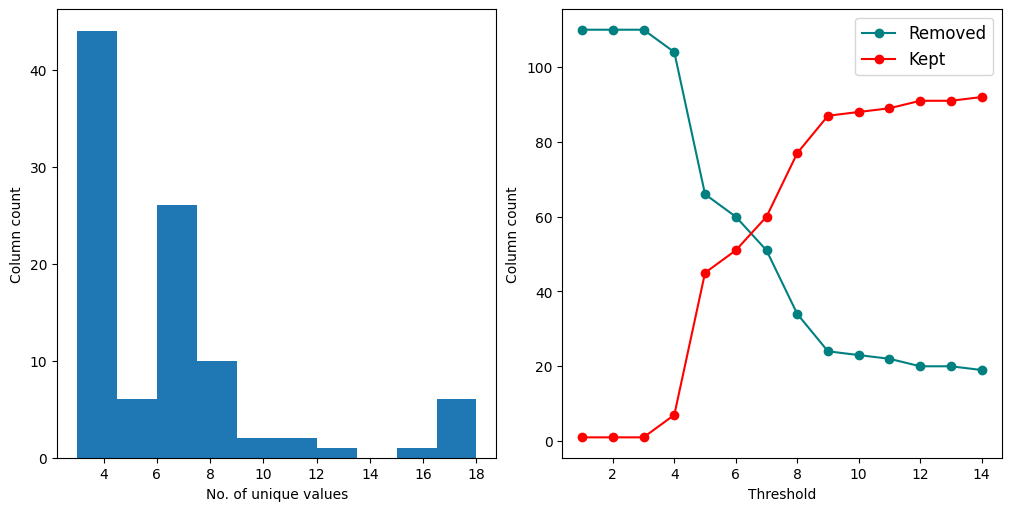

In [140]:
"""
From categorical columns, remove columns with a lot of unique values.These columns are likely to contain 
data such as dates, etc. These would not be helpful with the analysis. Let's perform simple plots to determine
an optimal threshold for the number of unique values a column should have in our analysis.
"""

# Let's use a plot to determine the number of columns to keep
# Idea: Pick a threshold number where the number of categorical columsn removed stabilises

removed_cnt = []
kept_cnt = []
thresholds = [_ for _ in range(1,15)]
for threshold in thresholds:
    removed_categorical_cols = set([col for col in categorical_cols if corr_df[col].nunique() >= threshold])
    kept_categorical_cols = set(corr_df.columns) - removed_categorical_cols
    
    removed_cnt.append(len(list(removed_categorical_cols)))
    kept_cnt.append(len(list(kept_categorical_cols)))

value_cnt = [corr_df[col].nunique() for col in categorical_cols]
value_cnt = [cnt for cnt in value_cnt if cnt <= 20]

plt.rcParams['figure.figsize'] = [10, 5]
fig, axs = plt.subplots(1, 2, constrained_layout = True)

axs[0].hist(value_cnt)
axs[0].set_xlabel('No. of unique values', fontsize = 10)
axs[0].set_ylabel('Column count', fontsize = 10)

axs[1].plot(thresholds, removed_cnt, marker='o', color = 'teal', label = 'Removed')
axs[1].plot(thresholds, kept_cnt, marker='o', color = 'red', label = 'Kept')
axs[1].legend(loc='upper right', fontsize = 12)
axs[1].set_xlabel('Threshold', fontsize = 10)
axs[1].set_ylabel('Column count', fontsize = 10)

In [141]:
"""
Using a threshold of 8, remove categorical columns with more than 8 unique values
"""

threshold = 8
categorical_cols = [col for col in categorical_cols if corr_df[col].nunique() <= threshold]
print(f'No. of categorical columns kept: {len(categorical_cols)}')

# Get the new dataset with kept categorical columns and response variable, _MICHD
corr_df = corr_df[categorical_cols]
corr_df = pd.merge(corr_df, y_train, on = 'pid')
corr_df.head()

No. of categorical columns kept: 86


,FLUSHOT6,PNEUVAC3,HIVTST6,PDIABTST,PREDIAB1,INSULIN,EYEEXAM,DIABEYE,DIABEDU,CAREGIV1,...,SCNTLPAD,SXORIENT,TRNSGNDR,RCSGENDR,RCSRLTN2,CASTHDX2,CASTHNO2,EMTSUPRT,LSATISFY,_MICHD
pid,,,,,,,,,,,,,,,,,,,,,
0,1.0,2.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2,1.0,2.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,1.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,0
3,2.0,2.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,2.0,...,NaN,1.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,0
4,2.0,2.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,1.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,0


In [147]:
"""
Get no. of missing values for each column. Then, identify columns with more than 80% of values being NaN.
These columns will be removed from further analysis.
"""

ttal_cnt = len(corr_df['_MICHD'])
nan_nonmajority_cols = [col for col in corr_df.columns if corr_df[col].isna().sum() / ttal_cnt < 0.8]
print(f'No. of columns with <80% of values being NaN: {len(nan_nonmajority_cols)}')

corr_df = corr_df[nan_nonmajority_cols]
corr_df.head()

No. of columns with <80% of values being NaN: 8


,FLUSHOT6,PNEUVAC3,HIVTST6,CAREGIV1,CIMEMLOS,SXORIENT,TRNSGNDR,_MICHD
pid,,,,,,,,
0,1.0,2.0,2.0,NaN,NaN,NaN,NaN,0
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2,1.0,2.0,2.0,NaN,NaN,1.0,4.0,0
3,2.0,2.0,2.0,2.0,NaN,1.0,4.0,0
4,2.0,2.0,2.0,NaN,NaN,1.0,4.0,0


In [149]:
# Drop response variable for now
corr_df = corr_df.drop(['_MICHD'], axis = 1)
corr_df.head()

,FLUSHOT6,PNEUVAC3,HIVTST6,CAREGIV1,CIMEMLOS,SXORIENT,TRNSGNDR
pid,,,,,,,
0,1.0,2.0,2.0,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1.0,2.0,2.0,NaN,NaN,1.0,4.0
3,2.0,2.0,2.0,2.0,NaN,1.0,4.0
4,2.0,2.0,2.0,NaN,NaN,1.0,4.0


## Description of the remainding columns

`FLUSHOT6`: Adults aged 65+ who have had a flu shot within the past year <br/>
`PNEUVAC3`: Adults aged 65+ who have ever had a pneumonia vaccination <br/>
`HIVTST6`: Adults who have ever been tested for HIV <br/>
`CAREGIV1`: During the past 30 days, did you provide regular care or assistance to a friend or family member who has a health problem or disability? <br/>
`CIMEMLOS`: During the past 12 months, have you experienced confusion or memory loss that is happening more often or is getting worse? <br/>
`SXORIENT`: Do you consider yourself to be: (We ask this question in order to better understand the health and health care needs of people with different sexual orientations.) <br/>
`TRNSGNDR`: Do you consider yourself to be transgender? (If yes, ask “Do you consider yourself to be male-to-female, female-to-male, or gender non-conforming?) <br/>

FLUSHOT6     30600
PNEUVAC3     31022
HIVTST6      32080
CAREGIV1    247299
CIMEMLOS    241493
SXORIENT    203924
TRNSGNDR    203990
dtype: int64


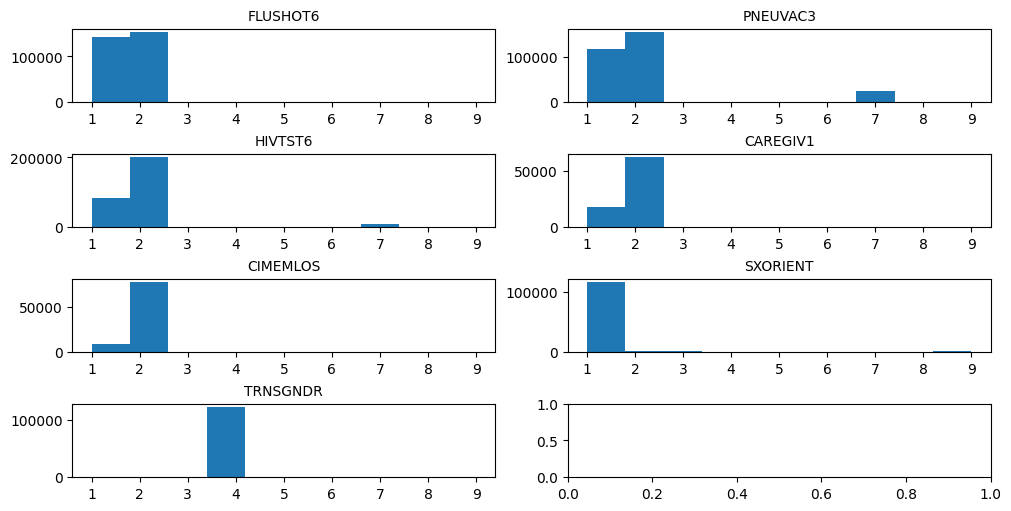

In [158]:
"""
Observe what percentage of values are NaN in the remaining columns and their distribution.
"""

nan_cnt = corr_df.isna().sum()
print(nan_cnt)

plt.rcParams['figure.figsize'] = [10, 5]
fig, axs = plt.subplots(4, 2, constrained_layout = True)

cols = list(corr_df.columns)

for i in range(4):
    for j in range(2):
        
        if (2*i) + j >= len(cols):
            break
            
        axs[i][j].hist(corr_df[cols[(2*i)+j]])
        axs[i][j].set_title(cols[(2*i)+j], fontsize = 10)
    
    
    if (2*i) + j >= len(cols):
        break        

FLUSHOT6    0
PNEUVAC3    0
HIVTST6     0
CAREGIV1    0
CIMEMLOS    0
SXORIENT    0
TRNSGNDR    0
dtype: int64


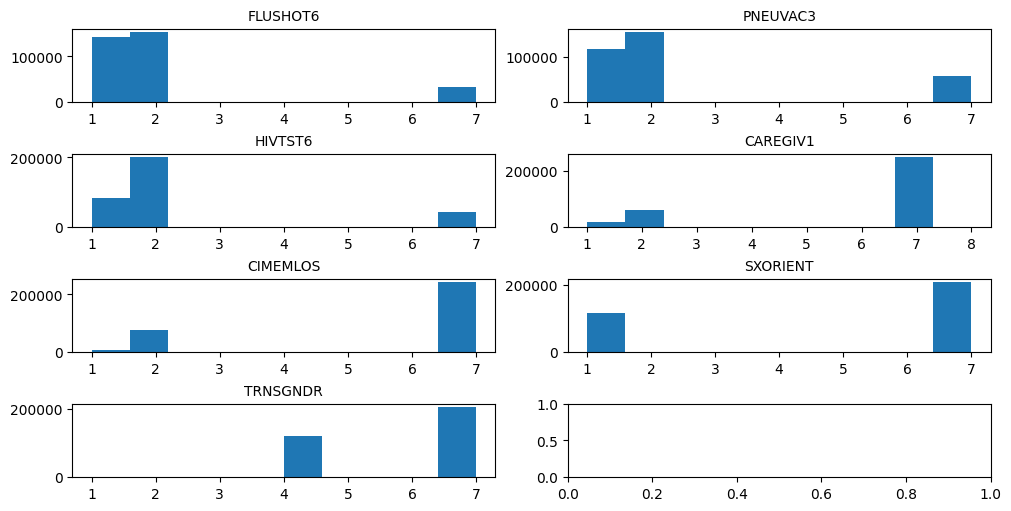

In [164]:
"""
NaN values are left blank as they are not asked or the data is missing. This is equivalent to an uncertain answer
of ignorance or uncertainty. Hence, NaN values will be filled as 'Don't know/ Not Sure'. Similarly, 'Refused' should
be filled with 'Don't know/ Not Sure' as well.

<u>Important categorical value</u>
- FLUSHOT6: 7 for don't know/ not sure, 9 for refused
- PNEUVAC3: 7 for don't know/ not sure, 9 for refused
- HIVTST6: 7 for don't know/ not sure, 9 for refused
- CAREGIV1: 7 for don't know/ not sure, 9 for refused
- CIMEMLOS: 7 for don't know/ not sure, 9 for refused
- SXORIENT: 7 for don't know/ not sure, 9 for refused
- TRNSGNDER: 7 for don't know/ not sure, 9 for refused
"""

# Fill NaN values and '9's with 7
corr_df = corr_df.apply(lambda col: col.fillna(7))
corr_df = corr_df.replace(9, 7)

nan_cnt = corr_df.isna().sum()
print(nan_cnt)

plt.rcParams['figure.figsize'] = [10, 5]
fig, axs = plt.subplots(4, 2, constrained_layout = True)

cols = list(corr_df.columns)

for i in range(4):
    for j in range(2):
        
        if (2*i) + j >= len(cols):
            break
            
        axs[i][j].hist(corr_df[cols[(2*i)+j]])
        axs[i][j].set_title(cols[(2*i)+j], fontsize = 10)
    
    
    if (2*i) + j >= len(cols):
        break        

## Generate one-hot encoding binary features to perform biserial correlation computation

In [170]:
cols = corr_df.columns
for col in cols:
    print(corr_df[col].unique())

[1. 7. 2.]
[2. 7. 1.]
[2. 7. 1.]
[7. 2. 1. 8.]
[7. 2. 1.]
[7. 1. 2. 3. 4.]
[7. 4. 3. 1. 2.]


In [178]:
"""
Transform categorical columns into binary columns using sklearn.preprocessing OneHotEncoder
"""

from sklearn.preprocessing import OneHotEncoder

categorical_cols = corr_df.columns

# Initialize the OneHotEncoder
encoder = OneHotEncoder(sparse = False)

# Transform the categorical columns
encoded_corr_df = encoder.fit_transform(corr_df[categorical_cols])

# Create a DataFrame with the encoded columns
encoded_corr_df = pd.DataFrame(encoded_corr_df, columns=encoder.get_feature_names_out(categorical_cols))

# Combine the new DataFrame with the original one
combined_corr_df = pd.concat([corr_df, encoded_corr_df], axis=1)

# Drop the original categorical columns
encoded_corr_df = combined_corr_df.drop(categorical_cols, axis=1)

encoded_corr_df.head()

/opt/jlab-env/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


,FLUSHOT6_1.0,FLUSHOT6_2.0,FLUSHOT6_7.0,PNEUVAC3_1.0,PNEUVAC3_2.0,PNEUVAC3_7.0,HIVTST6_1.0,HIVTST6_2.0,HIVTST6_7.0,CAREGIV1_1.0,...,SXORIENT_1.0,SXORIENT_2.0,SXORIENT_3.0,SXORIENT_4.0,SXORIENT_7.0,TRNSGNDR_1.0,TRNSGNDR_2.0,TRNSGNDR_3.0,TRNSGNDR_4.0,TRNSGNDR_7.0
0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
1,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
2,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [179]:
"""
Add back response variable column and compute correlation coefficient with each variable
"""

encoded_corr_df.index.name = 'pid'
encoded_corr_df = pd.merge(encoded_corr_df, y_train, on = 'pid')
encoded_corr_df.head()

,FLUSHOT6_1.0,FLUSHOT6_2.0,FLUSHOT6_7.0,PNEUVAC3_1.0,PNEUVAC3_2.0,PNEUVAC3_7.0,HIVTST6_1.0,HIVTST6_2.0,HIVTST6_7.0,CAREGIV1_1.0,...,SXORIENT_2.0,SXORIENT_3.0,SXORIENT_4.0,SXORIENT_7.0,TRNSGNDR_1.0,TRNSGNDR_2.0,TRNSGNDR_3.0,TRNSGNDR_4.0,TRNSGNDR_7.0,_MICHD
pid,,,,,,,,,,,,,,,,,,,,,
0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0
1,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0
2,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0
3,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0
4,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0


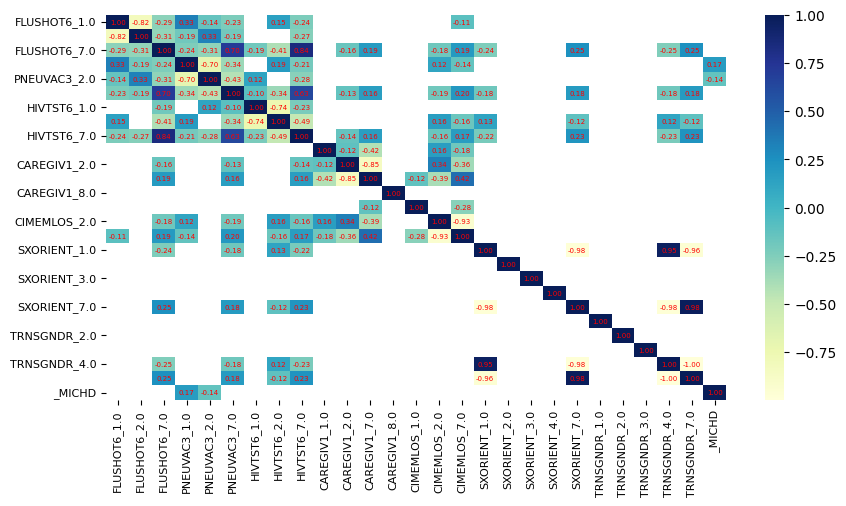

In [212]:
# Calculate the correlation matrix
corr_matrix = encoded_corr_df.corr()

# Create a mask to identify cells with correlation > 0.5 or < -0.5
mask = (corr_matrix > 0.1) | (corr_matrix < -0.1)

# Original plot
# sb.heatmap(corr_matrix, annot=False, cmap='YlGnBu')

# Generate the heatmap with custom annotations
sb.heatmap(corr_matrix, annot=False, cmap='YlGnBu', mask=~mask)

# Add your custom annotations
for i in range(len(corr_matrix)):
    for j in range(len(corr_matrix)):
        if mask.iloc[i, j]:
            plt.text(j+0.5, i+0.5, f"{corr_matrix.iloc[i, j]:.2f}", ha='center', va='center', fontsize=5, color='red')

plt.xticks(fontsize = 8)
plt.yticks(fontsize = 8)

# Show the plot
plt.show()